# Libraries

In [30]:
from tqdm import tqdm  
import joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                           roc_curve, precision_score, recall_score, f1_score, accuracy_score)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.utils import resample
import shap
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm  
import joblib

import mlflow

pd.set_option('display.max_columns', None)

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 34, Finished, Available, Finished)

# ML Model (Class functions)

**Funcionalidades Implementadas:**

**1. Separação Temporal dos Dados:**

Dados de 2015-2022 para treino
Dados de 2023 para teste

**2. Balanceamento de Dados (3:1 ratio):**

SMOTE para data augmentation
SMOTE + Tomek Links para melhor qualidade
Opção de undersampling tradicional

**3. Cross-Validation:**

StratifiedKFold para manter proporções
Múltiplas métricas de avaliação

**4. Hyperparameter Tuning:**

RandomizedSearchCV para eficiência
Grid abrangente de parâmetros XGBoost
Otimização baseada em AUC

**5. Métricas Completas:**

Accuracy, Precision, Recall, F1-Score
AUC e 2×AUC-1
Confusion Matrix
Curva ROC

**6. Visualizações:**

Confusion matrixes (treino e teste)
Curva ROC comparativa
Distribuição de probabilidades
Feature importance

In [31]:
def preprocess_features(path):
    """
    Pré-processamento das features
    """
    
    df = pd.read_csv(path, sep=';').drop(columns=['estciv_final_num', 'flag_garant', 'naciona_final_num', 'SALDO_PONTUAL', 'naciona_rend_num', 'envolvimento'])

    df['ESFORCO'] = df['EXPOSICAO'] / (df['med_rend_disp'] * 12)

    df["RISCO_HABIT_ESTCIV"] = df[[
        "best_estciv",
        "best_estciv",
        "pior_habitacao",
        "best_habitacao"
    ]].mean(axis=1)

    df["SALDO_PONTUAL"] = (
        df["SLDPNTBSCAP1M"] +
        df["SLDPNTBSPPR"] +
        df["SLDPNTFUND"] +
        df["SLDPNTDEPPRZ"] +
        df["SLDPNTOUTDES"]
    )

    df['risco_proff'] = df['best_prof2'] + df['pior_prof2']
    df['risco_origem'] = df['max_risco_origem2'] + df['min_risco_origem2']
    df['vinc_lab'] =  df[["best_prof2", "pior_prof2"]].max(axis=1)

    condicoes = [
        (df["SLDULTRESM"] <= 25.333) & (df["NUM_DEB_FINALtc"] <= 6.5),
        (df["SLDULTRESM"] > 25.333) & (df["SLDULTRESM"] <= 134.833) & (df["NUM_DEB_FINALtc"] <= 6.5),
        (df["SLDULTRESM"] <= 134.833) & (df["NUM_DEB_FINALtc"] > 6.5) & (df["NUM_DEB_FINALtc"] <= 8.5),
        (df["SLDULTRESM"] <= 134.833) & (df["NUM_DEB_FINALtc"] > 8.5),
        (df["SLDULTRESM"] > 134.833) & (df["NUM_DEB_FINALtc"] <= 63.5) & (df["ANTCONTA1"] <= 1.5),
        (df["SLDULTRESM"] > 134.833) & (df["NUM_DEB_FINALtc"] <= 63.5) & (df["ANTCONTA1"] > 1.5),
        (df["SLDULTRESM"] > 134.833) & (df["SLDULTRESM"] <= 3438.667) & (df["NUM_DEB_FINALtc"] > 63.5)
    ]

    envolvimentos = [1, 2, 3, 4, 5, 6, 7]
    df['envolvimento'] = np.select(condicoes, envolvimentos, default=8)

    # Selecionar as variáveis e preencher NAs com 0 (ou usar outra estratégia se fizer sentido)
    X = df[["avg_dependentes", "med_idade_filhos", "med_filhos"]]

    scaler = StandardScaler()
    X_dep_scaled = scaler.fit_transform(X)

    inertia = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_dep_scaled)
        inertia.append(kmeans.inertia_)

    kmeans = KMeans(n_clusters=4, random_state=42)
    df["Dependentes_cluster"] = kmeans.fit_predict(X_dep_scaled)

    #df["NRDIASDEVEDOR_LAG_12M"] = df.groupby("IDRFME")["NRDIASDEVEDOR"].shift(12)
    # Média móvel dos 6 últimos meses (sem incluir o mês atual)
    #df["NRDIASDEVEDOR_MM6M_PAST"] = df.groupby("IDRFME")["NRDIASDEVEDOR"].transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).mean())
    # Média móvel dos 12 últimos meses (sem incluir o mês atual)
    #df["NRDIASDEVEDOR_MM12M_PAST"] = df.groupby("IDRFME")["NRDIASDEVEDOR"].transform(lambda x: x.shift(1).rolling(window=12, min_periods=1).mean())
    #df["SALDO_PONTUAL_MM6M_PAST"] = df.groupby("IDRFME")["SALDO_PONTUAL"].transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).mean())
    # Média móvel dos 12 últimos meses (sem incluir o mês atual)
    #df["SALDO_PONTUAL_MM12M_PAST"] = df.groupby("IDRFME")["SALDO_PONTUAL"].transform(lambda x: x.shift(1).rolling(window=12, min_periods=1).mean())

    # para nao originação adicionar variaveis med, sld, desvios padrao, mm etc

    cols = [
        'IDRFME', 'DTREF', 'TIMEID', 'REC_PRAZO', 'SLDULTRESM', 'SLDPNTDO', 'n_tit_domvenc',
        'TXESFGLOBAL', 'DO_PREST', 'FINALIDADE', 'INDRESTRUT_num', 'PRAZO', 'DUMMYPRAZO72_84',
        'DUMMYPRAZOSUP84','VARIOS_TITULARES', 'ESFORCO', "RISCO_HABIT_ESTCIV", "SALDO_PONTUAL",
        "risco_proff", "risco_origem", "vinc_lab", "envolvimento", "NRDIASDEVEDOR", "Dependentes_cluster", "DEF_12"
    ]

    df = df[cols]

    return df

def load_and_prepare_data(df, target_column, date_column, year_partition):
        """
        Carrega e prepara os dados, separando por ano

        """

        # Converter coluna de data se necessário
        df[date_column] = pd.to_datetime(df[date_column])
        df['year'] = df[date_column].dt.year
        
        # Separar dados de treino e teste
        train_data = df[df['year'] < year_partition].copy()
        test_data = df[df['year'] == year_partition].copy()
        
        # Remover colunas não necessárias
        columns_to_drop = [date_column, 'year', "TIMEID", "IDRFME"]
        X_train = train_data.drop(columns_to_drop + [target_column], axis=1)
        y_train = train_data[target_column]
        
        X_test = test_data.drop(columns_to_drop + [target_column], axis=1)
        y_test = test_data[target_column]
        
        feature_names = X_train.columns.tolist()
        
        print(f"Dados de treino: {X_train.shape[0]} amostras ({y_train.sum()} defaults)")
        print(f"Dados de teste: {X_test.shape[0]} amostras ({y_test.sum()} defaults)")
        print(f"Taxa de default no treino: {y_train.mean():.3f}")
        print(f"Taxa de default no teste: {y_test.mean():.3f}")

        X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled, y_train, y_test, feature_names


def balance_data(X_train, y_train, target_column, method='undersample'):
    """
    Balanceamento dos dados sem SMOTE
    """
    print(f"\nDistribuição original: {np.bincount(y_train)}")
    
    if method == 'undersample':
        # Undersampling para atingir proporção 3:1
        df_train = pd.DataFrame(X_train)
        df_train[target_column] = y_train
        
        df_majority = df_train[df_train[target_column] == 0]
        df_minority = df_train[df_train[target_column] == 1]
        
        n_minority = len(df_minority)
        n_majority_target = n_minority * 3
        
        # Garante que não pedimos mais amostras do que temos
        n_majority_target = min(n_majority_target, len(df_majority))
        
        df_majority_downsampled = resample(df_majority, 
                                            replace=False,
                                            n_samples=n_majority_target,
                                            random_state=42)
        
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
        
        X_balanced = df_balanced.drop(target_column, axis=1).values
        y_balanced = df_balanced[target_column].values
        
    elif method == 'oversample':
        # Oversampling da classe minoritária (duplicação simples)
        df_train = pd.DataFrame(X_train)
        df_train[target_column] = y_train
        
        df_majority = df_train[df_train[target_column] == 0]
        df_minority = df_train[df_train[target_column] == 1]
        
        n_majority = len(df_majority)
        n_minority_target = n_majority // 3
        
        df_minority_upsampled = resample(df_minority,
                                        replace=True,
                                        n_samples=n_minority_target,
                                        random_state=42)
        
        df_balanced = pd.concat([df_majority, df_minority_upsampled])
        
        X_balanced = df_balanced.drop(target_column, axis=1).values
        y_balanced = df_balanced[target_column].values
    
    print(f"Distribuição balanceada: {np.bincount(y_balanced.astype(int))}")
    print(f"Nova proporção: {y_balanced.mean():.3f}")
    
    return X_balanced, y_balanced


def hyperparameter_tuning(X_train, y_train, cv_folds=5):
    """
    Hyperparameter tuning com RandomizedSearchCV
    """
    print("\nIniciando hyperparameter tuning...")
    
    # Grid de parâmetros para XGBoost
    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [1, 1.5, 2, 5],
        'min_child_weight': [1, 3, 5, 7]
    }
    
    # XGBoost com parâmetros base
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    )
    
    # RandomizedSearchCV para eficiência
    random_search = RandomizedSearchCV(
        xgb_model,
        param_distributions=param_grid,
        n_iter=50,
        cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    best_params = random_search.best_params_
    print(f"Melhores parâmetros: {best_params}")
    print(f"Melhor score CV: {random_search.best_score_:.4f}")
    
    return random_search.best_estimator_, best_params


def cross_validation_evaluation(model, X_train, y_train, cv_folds=5):
    """
    Avaliação com cross-validation
    """
    print("\nAvaliação com Cross-Validation:")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Múltiplas métricas
    scoring = ['roc_auc', 'precision', 'recall', 'f1', 'accuracy']
    cv_results = {}
    
    for metric in scoring:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=metric, n_jobs=-1)
        cv_results[metric] = scores
        print(f"{metric.upper()}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    
    return cv_results


def train_final_model(X_train, y_train, best_params):
    """
    Treina o modelo final com os melhores parâmetros
    """
    print("\nTreinando modelo final...")
    
    model = xgb.XGBClassifier(
        **best_params,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    return model

def evaluate_model(X_train, y_train, X_test, y_test, model):
    """
    Avaliação completa do modelo
    """
    # Predições
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas para treino
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'f1_score': f1_score(y_train, y_train_pred),
        'auc': roc_auc_score(y_train, y_train_proba),
        '2auc_1': 2 * roc_auc_score(y_train, y_train_proba) - 1
    }
    
    # Métricas para teste
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1_score': f1_score(y_test, y_test_pred),
        'auc': roc_auc_score(y_test, y_test_proba),
        '2auc_1': 2 * roc_auc_score(y_test, y_test_proba) - 1
    }
    
    return train_metrics, test_metrics, y_train_pred, y_test_pred, y_train_proba, y_test_proba


def print_metrics_report(train_metrics, test_metrics):
    """
    Imprime relatório completo das métricas
    """
    print("\n" + "="*60)
    print("RELATÓRIO DE MÉTRICAS DO MODELO")
    print("="*60)

    print("\nMÉTRICAS DE TREINO:")
    print("-" * 30)
    for metric, value in train_metrics.items():
        print(f"{metric.upper():>12}: {value:.4f}")

    print("\nMÉTRICAS DE TESTE:")
    print("-" * 30)
    for metric, value in test_metrics.items():
        print(f"{metric.upper():>12}: {value:.4f}")

    print("\nDIFERENÇA (Teste - Treino):")
    print("-" * 30)
    for metric in train_metrics.keys():
        diff = test_metrics[metric] - train_metrics[metric]
        print(f"{metric.upper():>12}: {diff:+.4f}")


def plot_results(y_train, y_test, y_train_pred, y_test_pred, 
                y_train_proba, y_test_proba, train_metrics, test_metrics, model, feature_names):
    """
    Visualização dos resultados
    """
    # Alterado para 2 linhas e 3 colunas (6 subplots no total)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Confusion Matrix - Treino
    cm_train = confusion_matrix(y_train, y_train_pred)
    #print("Matriz de Confusão - Treino:")
    #print(pd.DataFrame(cm_train))
    
    # Plot da matriz de confusão treino
    plot_confusion_matrix(axes[0, 0], cm_train, 'Matriz de Confusão - Treino')
    
    # Confusion Matrix - Teste
    cm_test = confusion_matrix(y_test, y_test_pred)
    #print("Matriz de Confusão - Teste:")
    #print(pd.DataFrame(cm_test))
    
    # Plot da matriz de confusão teste
    plot_confusion_matrix(axes[0, 1], cm_test, 'Matriz de Confusão - Teste')
    
    # ROC Curve (agora na posição [0, 2])
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
    
    axes[0, 2].plot(fpr_train, tpr_train, label=f'Treino (AUC = {train_metrics["auc"]:.3f})', color='pink')
    axes[0, 2].plot(fpr_test, tpr_test, label=f'Teste (AUC = {test_metrics["auc"]:.3f})', color='#179297')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5, color='grey')
    axes[0, 2].set_xlabel('Taxa de Falsos Positivos')
    axes[0, 2].set_ylabel('Taxa de Verdadeiros Positivos')
    axes[0, 2].set_title('Curva ROC')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Distribuição das probabilidades - Treino (agora na posição [1, 0])
    axes[1, 0].hist(y_train_proba[y_train==0], bins=50, alpha=0.7, label='Não Default', density=True, color='#179297')
    axes[1, 0].hist(y_train_proba[y_train==1], bins=50, alpha=0.7, label='Default', density=True, color='pink')
    axes[1, 0].set_xlabel('Probabilidade Predita')
    axes[1, 0].set_ylabel('Densidade')
    axes[1, 0].set_title('Distribuição de Probabilidades - Treino')
    axes[1, 0].legend()
    
    # Distribuição das probabilidades - Teste (agora na posição [1, 1])
    axes[1, 1].hist(y_test_proba[y_test==0], bins=50, alpha=0.7, label='Não Default', density=True, color='#179297')
    axes[1, 1].hist(y_test_proba[y_test==1], bins=50, alpha=0.7, label='Default', density=True, color='pink')
    axes[1, 1].set_xlabel('Probabilidade Predita')
    axes[1, 1].set_ylabel('Densidade')
    axes[1, 1].set_title('Distribuição de Probabilidades - Teste')
    axes[1, 1].legend()
    
    # Feature Importance (agora na posição [1, 2])
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=True).tail(10)
        
        axes[1, 2].barh(importance_df['feature'], importance_df['importance'], color='#179297')
        axes[1, 2].set_xlabel('Importância')
        axes[1, 2].set_title('Top 10 Features Mais Importantes')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(ax, cm, title):
    """Função auxiliar para plotar matriz de confusão"""
    labels = ['Não Default', 'Default']
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Real')
    ax.set_xlabel('Predito')
    
    # Adiciona os valores nas células
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")

def generate_shap_explanations(X_train, X_test, model):
    """
    Gera explicações SHAP para interpretabilidade do modelo
    """
    print("\nGerando explicações SHAP...")
    
    X_train_sample = X_train
    X_test_sample = X_test
    
    # Criar explainer SHAP
    explainer = shap.TreeExplainer(model)
    
    # Calcular SHAP values
    shap_values_train = explainer.shap_values(X_train_sample)
    shap_values_test = explainer.shap_values(X_test_sample)
    
    return explainer, shap_values_train, shap_values_test, X_train_sample, X_test_sample

def shap_global_importance(shap_values, feature_names, top_n=20):
    """
    Calcula importância global das features via SHAP
    """
    feature_importance = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': feature_importance
    }).sort_values('shap_importance', ascending=False).head(top_n)
    
    print(f"\nTop {top_n} Features por SHAP Importance:")
    print("-" * 50)
    for idx, row in importance_df.iterrows():
        print(f"{row['feature']:>25}: {row['shap_importance']:.4f}")
    
    return importance_df
    

def plot_shap_analysis(explainer, shap_values_test, X_test_sample, feature_names):
    """
    Cria 4 visualizações SHAP (teste) organizadas em sequência, sem sobreposição.
    """

    # 1. Summary plot - Importância (bar)
    shap.summary_plot(shap_values_test, X_test_sample,
                      feature_names=feature_names,
                      plot_type="bar", max_display=21)
    
    # 2. Summary plot - Efeitos
    shap.summary_plot(shap_values_test, X_test_sample,
                      feature_names=feature_names,
                      max_display=21)

    # 4. Waterfall plot para uma amostra
    # Encontrar índices onde a previsão é default (classe 1)
    default_indices = np.where(y_test_pred == 1)[0]

    # Pegar o primeiro cliente default como exemplo
    sample_idx = default_indices[0:3]

    print("Default predictions")
    for id in sample_idx:
        # Criar o objeto Explanation para o cliente default
        expl = shap.Explanation(
            values=shap_values_test[id],
            base_values=explainer.expected_value,
            data=X_test_sample[id], 
            feature_names=feature_names
        )

        # Plotar o waterfall plot
        shap.plots.waterfall(expl, max_display=10)

    # Encontrar índices onde a previsão é default (classe 0)
    non_default_indices = np.where(y_test_pred == 0)[0]

    # Pegar o primeiro cliente default como exemplo
    non_def_id = non_default_indices[32]

    expl = shap.Explanation(
        values=shap_values_test[non_def_id],
        base_values=explainer.expected_value,
        data=X_test[non_def_id],  
        feature_names=feature_names
    )

    print("Non default prediction")
    # Plotar o waterfall plot
    shap.plots.waterfall(expl, max_display=10)

    return None  # não retorna fig porque os plots são controlados pelo SHAP



StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 35, Finished, Available, Finished)

# Pipeline

## (Train & test)

In [38]:
path = "/lakehouse/default/Files/WorkerFactory/DADOS_NOVOS_CLIENTES.csv" #"/lakehouse/default/Files/WorkerFactory/AMOSTRA_NOVOS.csv"
df = preprocess_features(path)

X_train, X_test, y_train, y_test, feature_names = load_and_prepare_data(df, 'DEF_12', 'DTREF', 2023) 
X_train_balanced, y_train_balanced = balance_data(X_train, y_train, 'DEF_12', method='undersample')
best_model, best_params = hyperparameter_tuning(X_train_balanced, y_train_balanced, cv_folds=5)
cv_results = cross_validation_evaluation(best_model, X_train_balanced, y_train_balanced, cv_folds=5)
final_model = train_final_model(X_train_balanced, y_train_balanced, best_params)

final_model

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 42, Finished, Available, Finished)

Dados de treino: 11261 amostras (882 defaults)
Dados de teste: 2075 amostras (292 defaults)
Taxa de default no treino: 0.078
Taxa de default no teste: 0.141

Distribuição original: [10379   882]
Distribuição balanceada: [2643  881]
Nova proporção: 0.250

Iniciando hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


Melhores parâmetros: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Melhor score CV: 0.7069

Avaliação com Cross-Validation:
ROC_AUC: 0.7069 (+/- 0.0338)
PRECISION: 0.6052 (+/- 0.1950)
RECALL: 0.0908 (+/- 0.0482)
F1: 0.1567 (+/- 0.0728)
ACCURACY: 0.7574 (+/- 0.0137)

Treinando modelo final...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

## Model evalution 

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 43, Finished, Available, Finished)


RELATÓRIO DE MÉTRICAS DO MODELO

MÉTRICAS DE TREINO:
------------------------------
    ACCURACY: 0.9124
   PRECISION: 0.3629
      RECALL: 0.1576
    F1_SCORE: 0.2198
         AUC: 0.8138
      2AUC_1: 0.6276

MÉTRICAS DE TESTE:
------------------------------
    ACCURACY: 0.8342
   PRECISION: 0.2292
      RECALL: 0.0753
    F1_SCORE: 0.1134
         AUC: 0.6684
      2AUC_1: 0.3368

DIFERENÇA (Teste - Treino):
------------------------------
    ACCURACY: -0.0781
   PRECISION: -0.1338
      RECALL: -0.0823
    F1_SCORE: -0.1064
         AUC: -0.1454
      2AUC_1: -0.2908


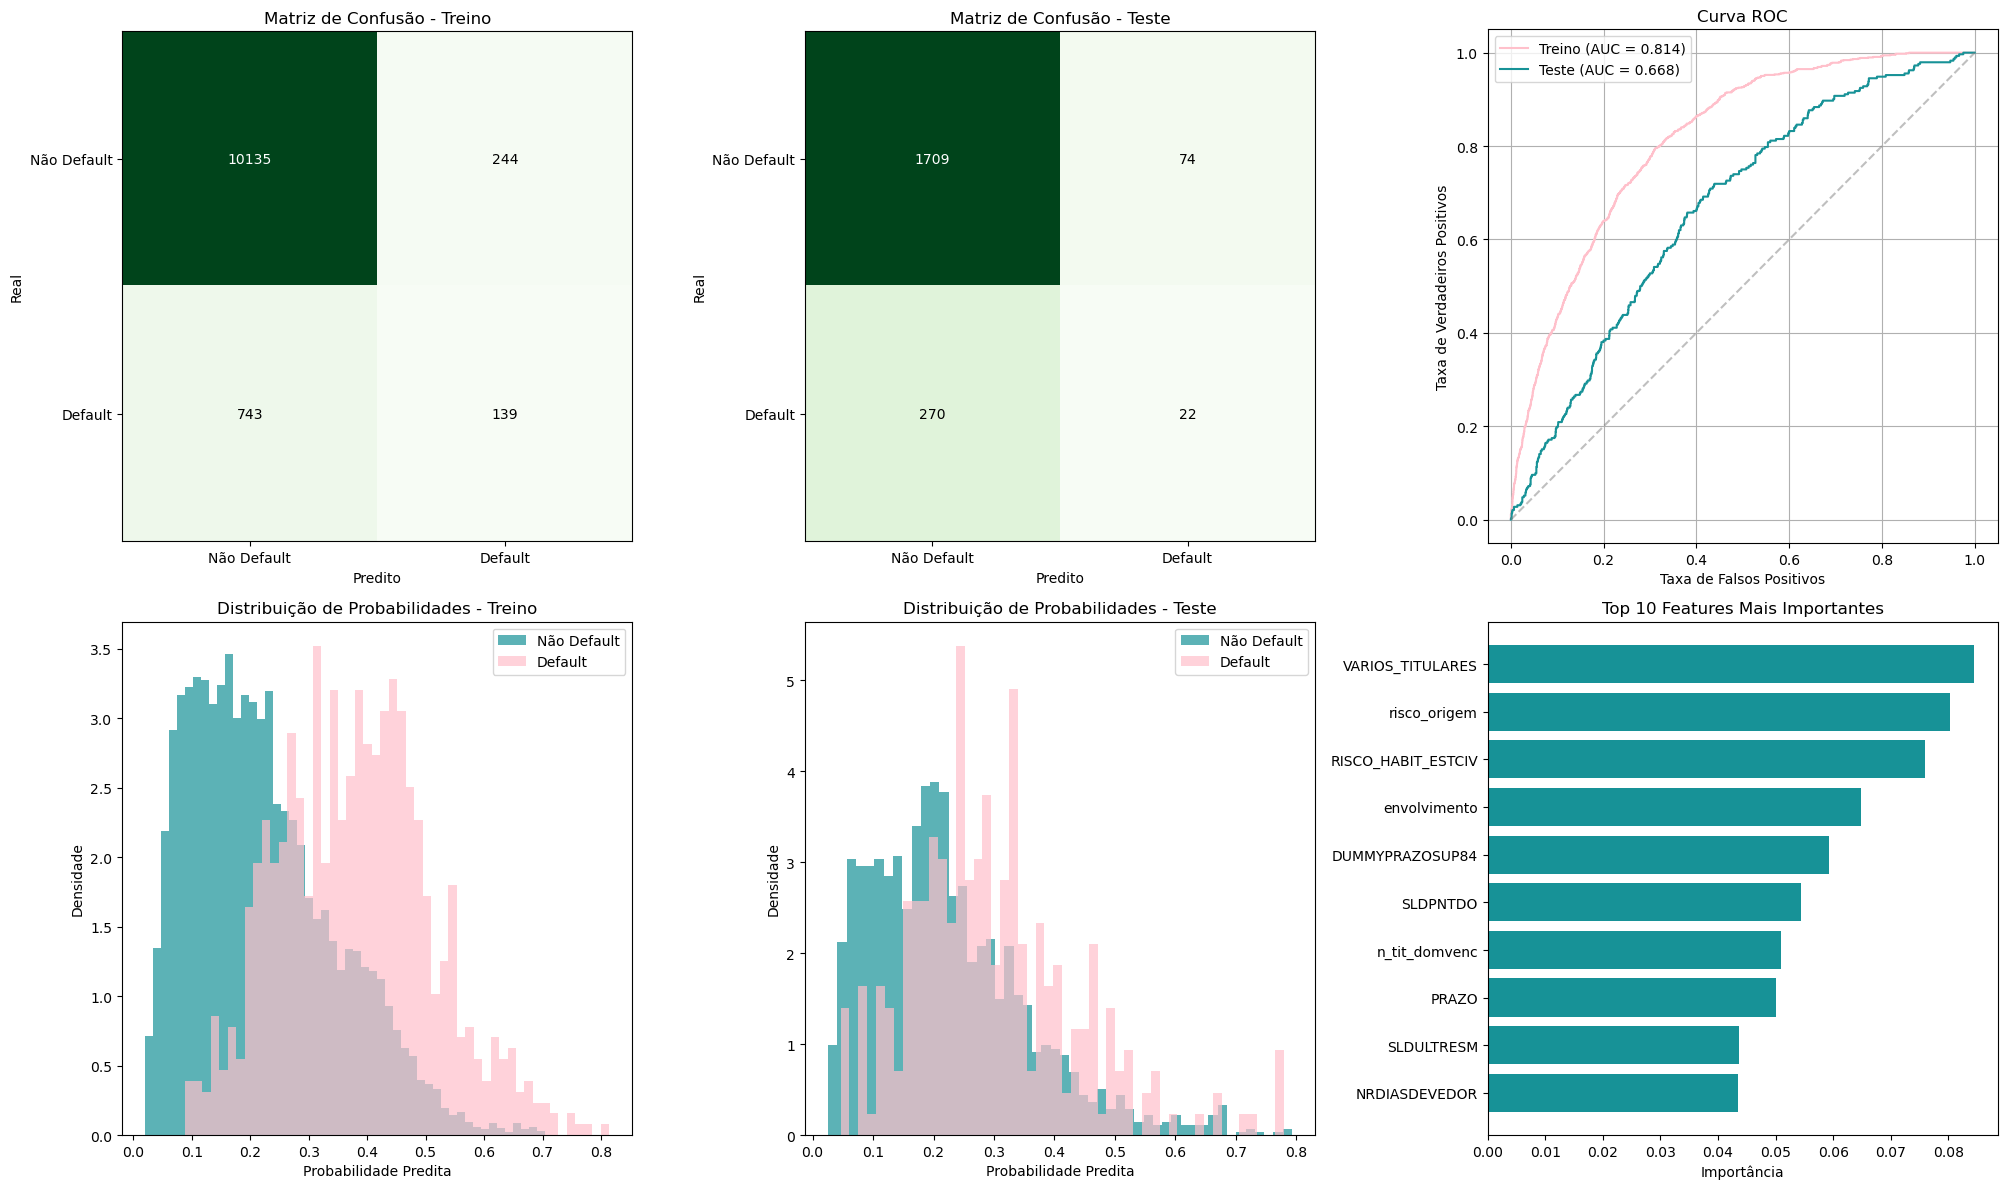

In [39]:
train_metrics, test_metrics, y_train_pred, y_test_pred, y_train_proba, y_test_proba = evaluate_model(X_train, y_train, X_test, y_test, final_model)

print_metrics_report(train_metrics, test_metrics)
plot_results(y_train, y_test, y_train_pred, y_test_pred,
                               y_train_proba, y_test_proba, train_metrics, test_metrics, final_model, feature_names)

## Model explainability

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 38, Finished, Available, Finished)


Gerando explicações SHAP...

Top 21 Features por SHAP Importance:
--------------------------------------------------
                 SLDPNTDO: 0.3193
       RISCO_HABIT_ESTCIV: 0.2609
                    PRAZO: 0.1883
         VARIOS_TITULARES: 0.1148
            n_tit_domvenc: 0.1125
             risco_origem: 0.0932
              risco_proff: 0.0889
             envolvimento: 0.0756
              TXESFGLOBAL: 0.0739
                  ESFORCO: 0.0729
               SLDULTRESM: 0.0440
                 DO_PREST: 0.0358
      Dependentes_cluster: 0.0258
            SALDO_PONTUAL: 0.0187
                 vinc_lab: 0.0149
                REC_PRAZO: 0.0147
          DUMMYPRAZOSUP84: 0.0134
            NRDIASDEVEDOR: 0.0102
          DUMMYPRAZO72_84: 0.0046
               FINALIDADE: 0.0034
           INDRESTRUT_num: 0.0028


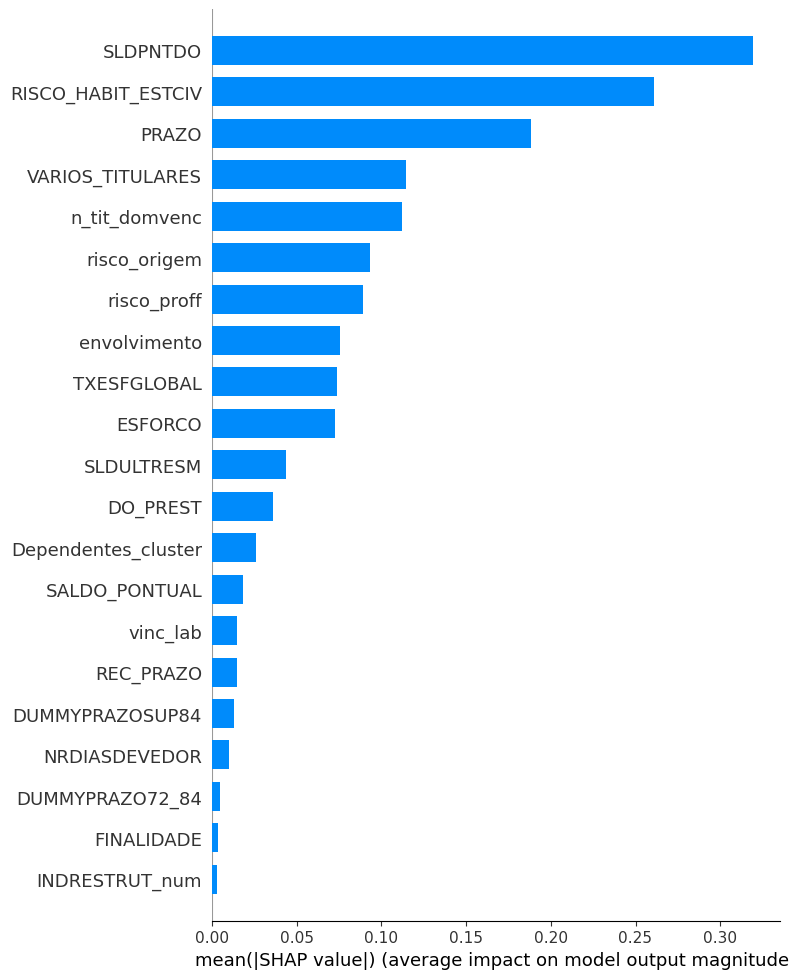

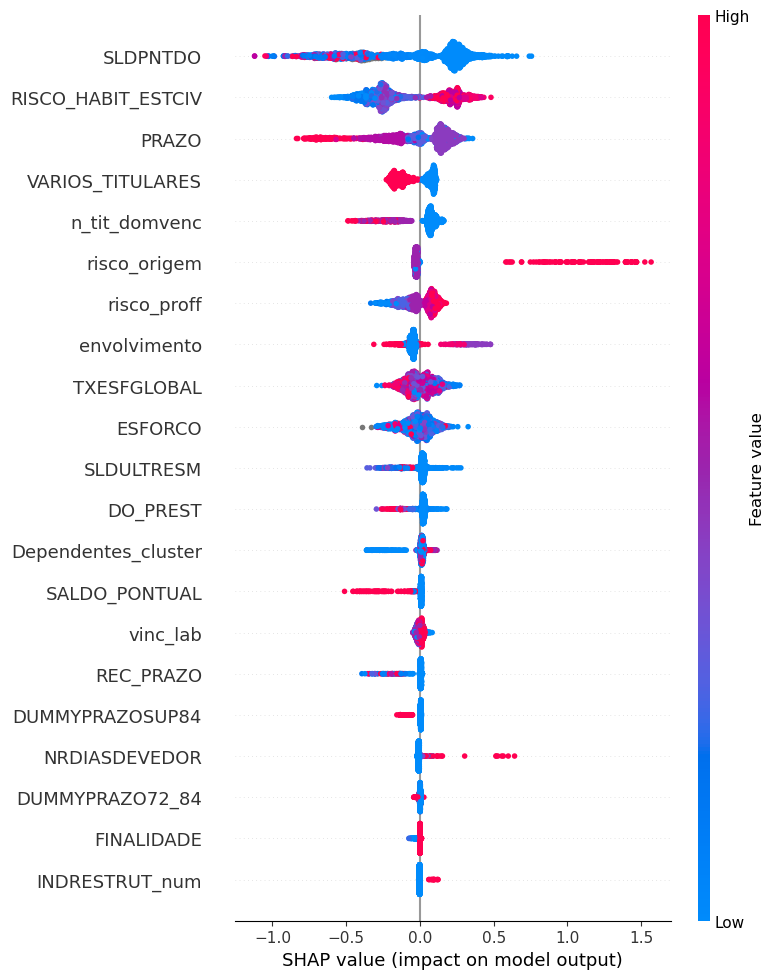

Default predictions


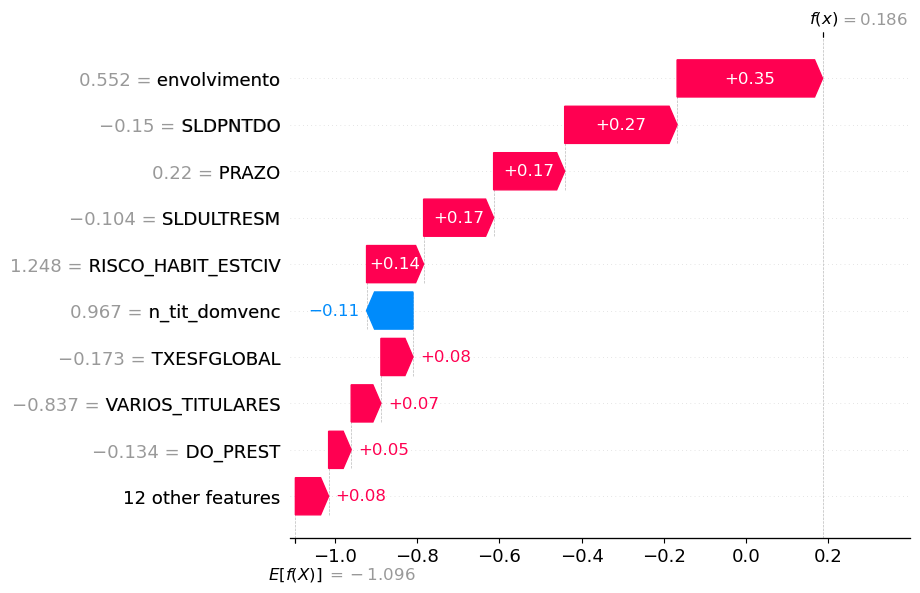

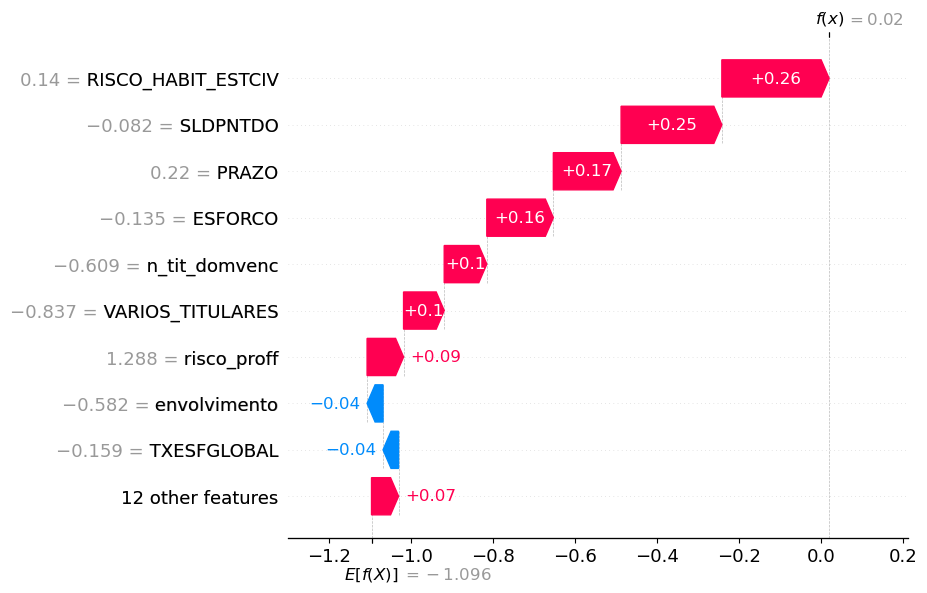

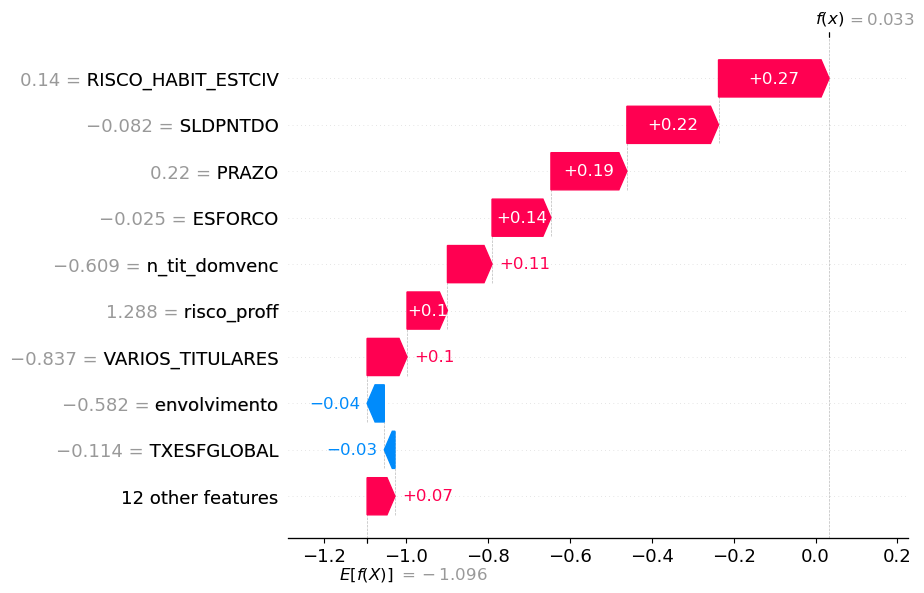

Non default prediction


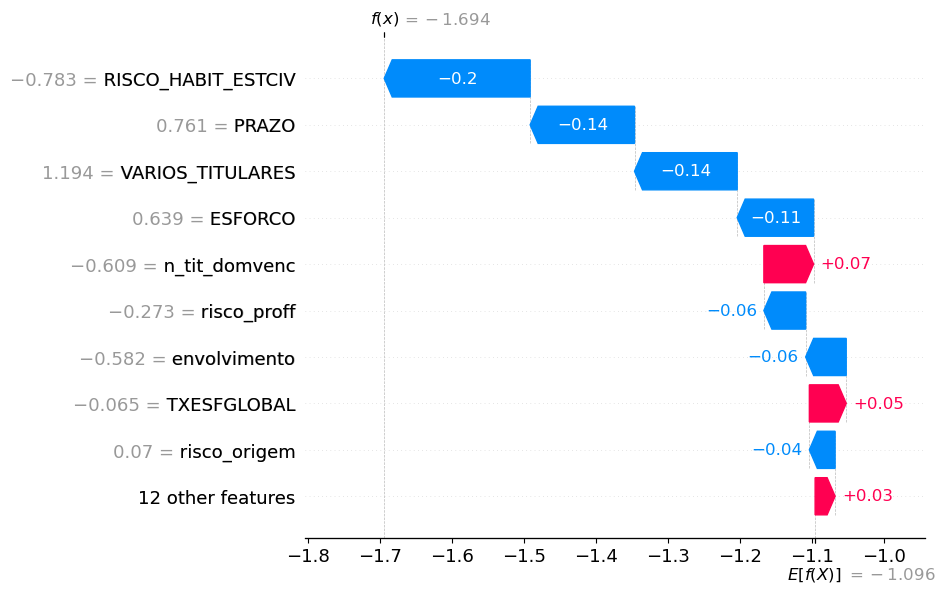

In [34]:
explainerx, shap_values_trainx, shap_values_testx, X_train_samplex, X_test_samplex = generate_shap_explanations(X_train, X_test, final_model)

importance_df = shap_global_importance(shap_values_testx, feature_names, top_n=21)

plot_shap_analysis(explainerx, shap_values_testx, X_test_samplex, feature_names)

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 39, Finished, Available, Finished)

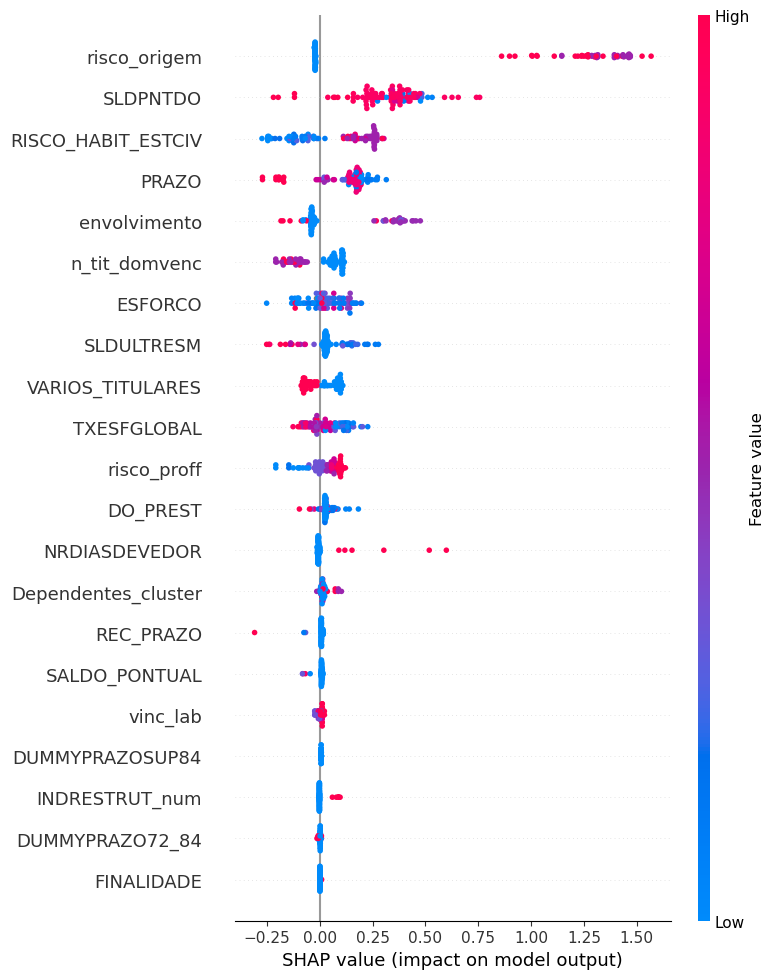

In [35]:
# Encontrar índices dos clientes default
indices_label1 = np.where(y_test_pred == 1)[0]

shap_values_label1 = shap_values_testx[indices_label1]
X_test_label1 = X_test_samplex[indices_label1]


shap.summary_plot(
    shap_values_label1, 
    pd.DataFrame(X_test_label1, columns=feature_names),
    feature_names=feature_names,
    max_display=21,
    title="SHAP Summary Plot (Apenas Clientes Default)"
)

# Clients model

In [45]:
def preprocess_features_v2(path):
    """
    Pré-processamento das features
    """
    
    df = pd.read_csv(path, sep=';').drop(columns=['estciv_final_num', 'naciona_final_num', 'SALDO_PONTUAL', 'naciona_rend_num', 'envolvimento'])

    df['ESFORCO'] = df['EXPOSICAO'] / (df['med_rend_disp'] * 12)

    df["RISCO_HABIT_ESTCIV"] = df[[
        "best_estciv",
        "best_estciv",
        "pior_habitacao",
        "best_habitacao"
    ]].mean(axis=1)

    df["SALDO_PONTUAL"] = (
        df["SLDPNTBSCAP1M"] +
        df["SLDPNTBSPPR"] +
        df["SLDPNTFUND"] +
        df["SLDPNTDEPPRZ"] +
        df["SLDPNTOUTDES"]
    )

    df['risco_proff'] = df['best_prof2'] + df['pior_prof2']
    df['risco_origem'] = df['max_risco_origem2'] + df['min_risco_origem2']
    df['vinc_lab'] =  df[["best_prof2", "pior_prof2"]].max(axis=1)

    condicoes = [
        (df["SLDULTRESM"] <= 25.333) & (df["NUM_DEB_FINALtc"] <= 6.5),
        (df["SLDULTRESM"] > 25.333) & (df["SLDULTRESM"] <= 134.833) & (df["NUM_DEB_FINALtc"] <= 6.5),
        (df["SLDULTRESM"] <= 134.833) & (df["NUM_DEB_FINALtc"] > 6.5) & (df["NUM_DEB_FINALtc"] <= 8.5),
        (df["SLDULTRESM"] <= 134.833) & (df["NUM_DEB_FINALtc"] > 8.5),
        (df["SLDULTRESM"] > 134.833) & (df["NUM_DEB_FINALtc"] <= 63.5) & (df["ANTCONTA1"] <= 1.5),
        (df["SLDULTRESM"] > 134.833) & (df["NUM_DEB_FINALtc"] <= 63.5) & (df["ANTCONTA1"] > 1.5),
        (df["SLDULTRESM"] > 134.833) & (df["SLDULTRESM"] <= 3438.667) & (df["NUM_DEB_FINALtc"] > 63.5)
    ]

    envolvimentos = [1, 2, 3, 4, 5, 6, 7]
    df['envolvimento'] = np.select(condicoes, envolvimentos, default=8)

    # Selecionar as variáveis e preencher NAs com 0 (ou usar outra estratégia se fizer sentido)
    X = df[["avg_dependentes", "med_idade_filhos", "med_filhos"]]

    scaler = StandardScaler()
    X_dep_scaled = scaler.fit_transform(X)

    inertia = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_dep_scaled)
        inertia.append(kmeans.inertia_)

    kmeans = KMeans(n_clusters=4, random_state=42)
    df["Dependentes_cluster"] = kmeans.fit_predict(X_dep_scaled)

    #df["NRDIASDEVEDOR_LAG_12M"] = df.groupby("IDRFME")["NRDIASDEVEDOR"].shift(12)
    # Média móvel dos 6 últimos meses (sem incluir o mês atual)
    #df["NRDIASDEVEDOR_MM6M_PAST"] = df.groupby("IDRFME")["NRDIASDEVEDOR"].transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).mean())
    # Média móvel dos 12 últimos meses (sem incluir o mês atual)
    #df["NRDIASDEVEDOR_MM12M_PAST"] = df.groupby("IDRFME")["NRDIASDEVEDOR"].transform(lambda x: x.shift(1).rolling(window=12, min_periods=1).mean())
    #df["SALDO_PONTUAL_MM6M_PAST"] = df.groupby("IDRFME")["SALDO_PONTUAL"].transform(lambda x: x.shift(1).rolling(window=6, min_periods=1).mean())
    # Média móvel dos 12 últimos meses (sem incluir o mês atual)
    #df["SALDO_PONTUAL_MM12M_PAST"] = df.groupby("IDRFME")["SALDO_PONTUAL"].transform(lambda x: x.shift(1).rolling(window=12, min_periods=1).mean())

    # para nao originação adicionar variaveis med, sld, desvios padrao, mm etc

    cols = [
        'IDRFME', 'DTREF', 'TIMEID', 'REC_PRAZO', 'SLDULTRESM', 'SLDPNTDO', 'n_tit_domvenc',
        'TXESFGLOBAL', 'DO_PREST', 'FINALIDADE', 'INDRESTRUT_num', 'PRAZO', 'DUMMYPRAZO72_84',
        'DUMMYPRAZOSUP84','VARIOS_TITULARES', 'ESFORCO', "RISCO_HABIT_ESTCIV", "SALDO_PONTUAL",
        "risco_proff", "risco_origem", "vinc_lab", "envolvimento", "NRDIASDEVEDOR", "Dependentes_cluster", "DEF_12"
    ]

    df = df[cols]

    return df

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 49, Finished, Available, Finished)

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 51, Finished, Available, Finished)

Dados de treino: 130348 amostras (3097 defaults)
Dados de teste: 19038 amostras (770 defaults)
Taxa de default no treino: 0.024
Taxa de default no teste: 0.040

Distribuição original: [127251   3097]
Distribuição balanceada: [9258 3086]
Nova proporção: 0.250

Iniciando hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


Melhores parâmetros: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Melhor score CV: 0.8318

Avaliação com Cross-Validation:
ROC_AUC: 0.8318 (+/- 0.0238)
PRECISION: 0.7067 (+/- 0.0504)
RECALL: 0.3713 (+/- 0.0382)
F1: 0.4868 (+/- 0.0436)
ACCURACY: 0.8044 (+/- 0.0144)

Treinando modelo final...



RELATÓRIO DE MÉTRICAS DO MODELO

MÉTRICAS DE TREINO:
------------------------------
    ACCURACY: 0.9378
   PRECISION: 0.1715
      RECALL: 0.4227
    F1_SCORE: 0.2440
         AUC: 0.8646
      2AUC_1: 0.7291

MÉTRICAS DE TESTE:
------------------------------
    ACCURACY: 0.9208
   PRECISION: 0.2166
      RECALL: 0.3662
    F1_SCORE: 0.2722
         AUC: 0.8300
      2AUC_1: 0.6600

DIFERENÇA (Teste - Treino):
------------------------------
    ACCURACY: -0.0170
   PRECISION: +0.0451
      RECALL: -0.0564
    F1_SCORE: +0.0282
         AUC: -0.0346
      2AUC_1: -0.0691


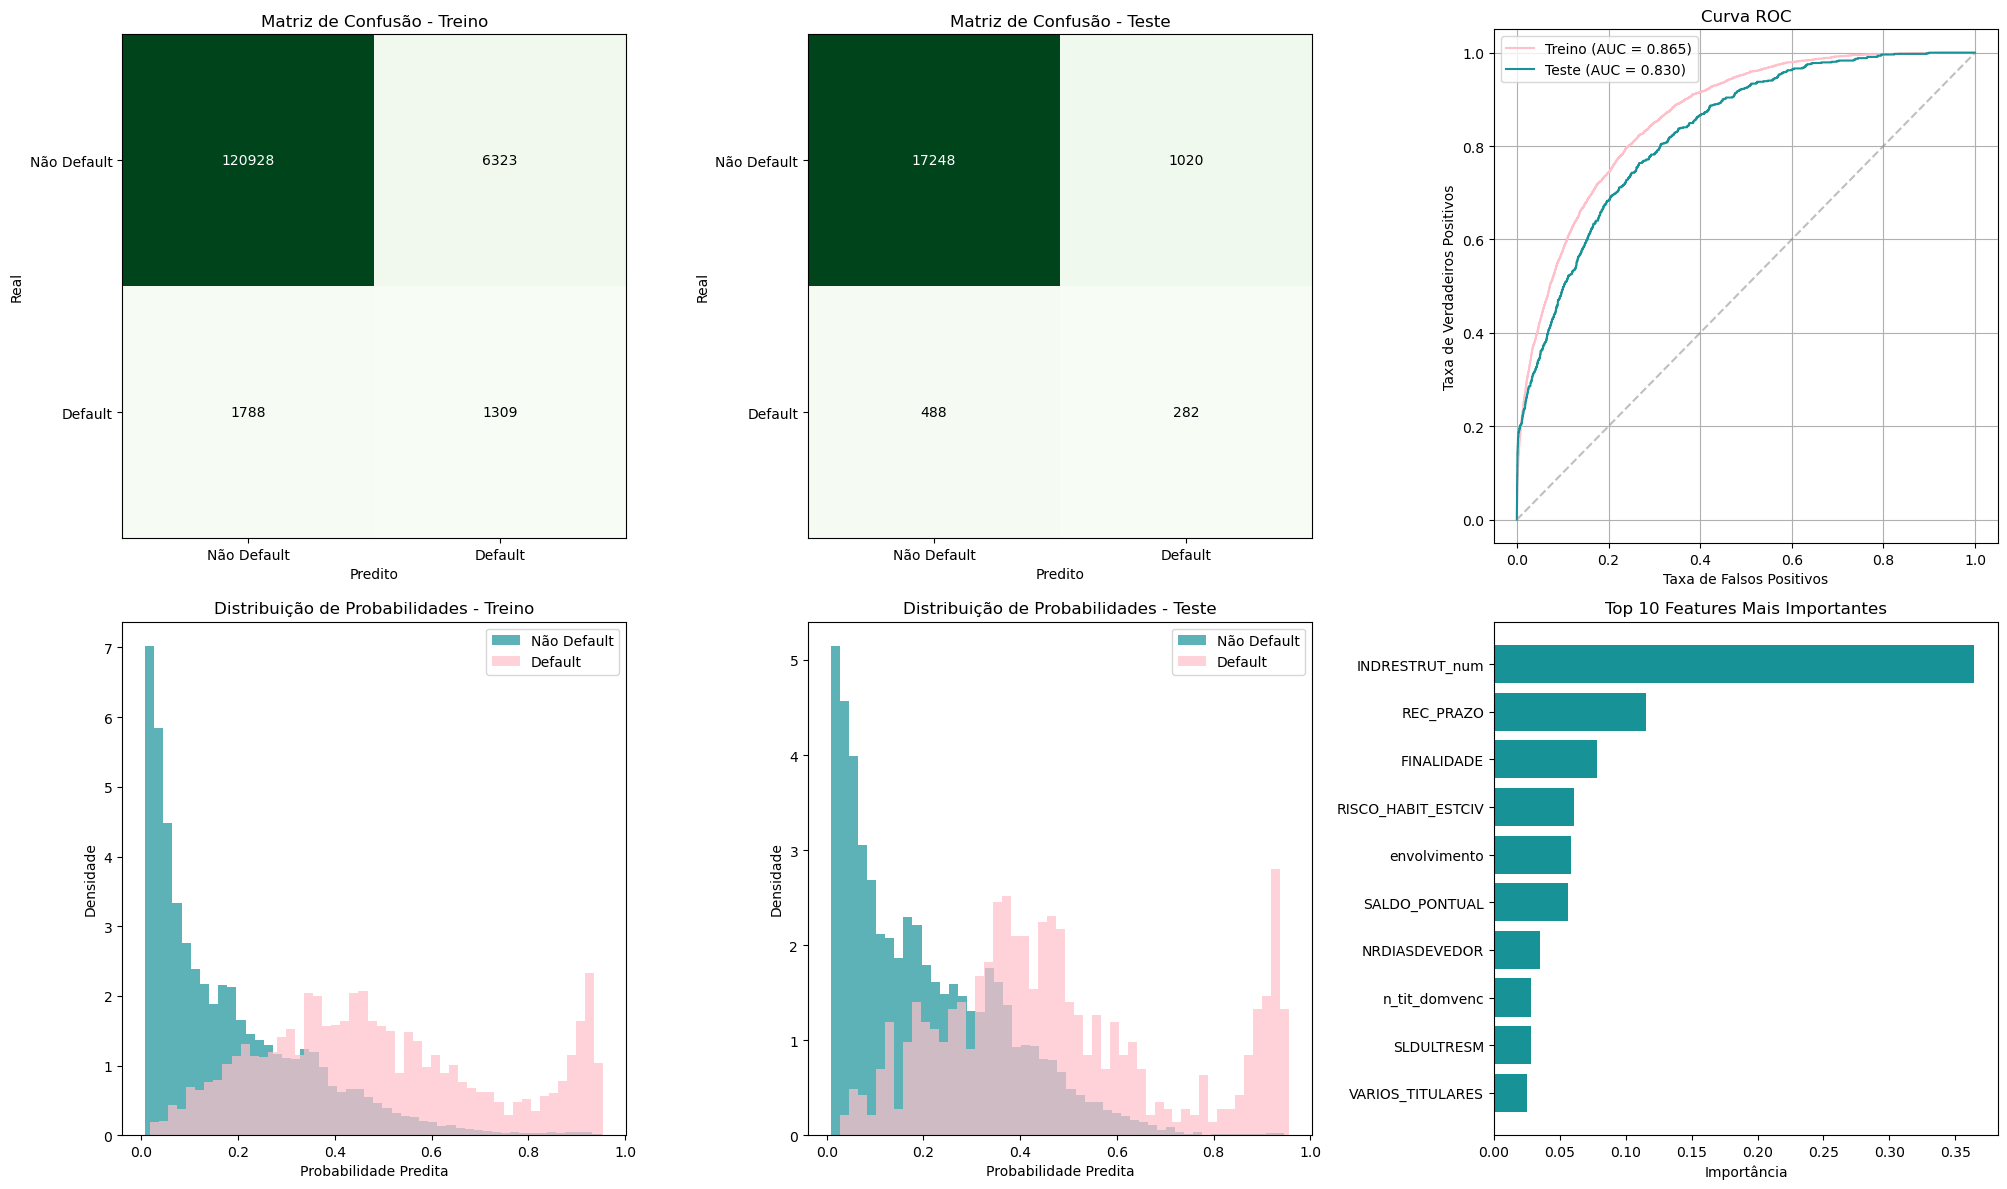


Gerando explicações SHAP...

Top 21 Features por SHAP Importance:
--------------------------------------------------
       RISCO_HABIT_ESTCIV: 0.4053
                REC_PRAZO: 0.3492
            SALDO_PONTUAL: 0.2532
            NRDIASDEVEDOR: 0.2021
                 SLDPNTDO: 0.1924
            n_tit_domvenc: 0.1170
             envolvimento: 0.1076
           INDRESTRUT_num: 0.1070
                    PRAZO: 0.1068
               SLDULTRESM: 0.0975
             risco_origem: 0.0759
               FINALIDADE: 0.0573
                  ESFORCO: 0.0472
              risco_proff: 0.0419
                 DO_PREST: 0.0405
              TXESFGLOBAL: 0.0292
                 vinc_lab: 0.0190
         VARIOS_TITULARES: 0.0094
      Dependentes_cluster: 0.0082
          DUMMYPRAZO72_84: 0.0043
          DUMMYPRAZOSUP84: 0.0002


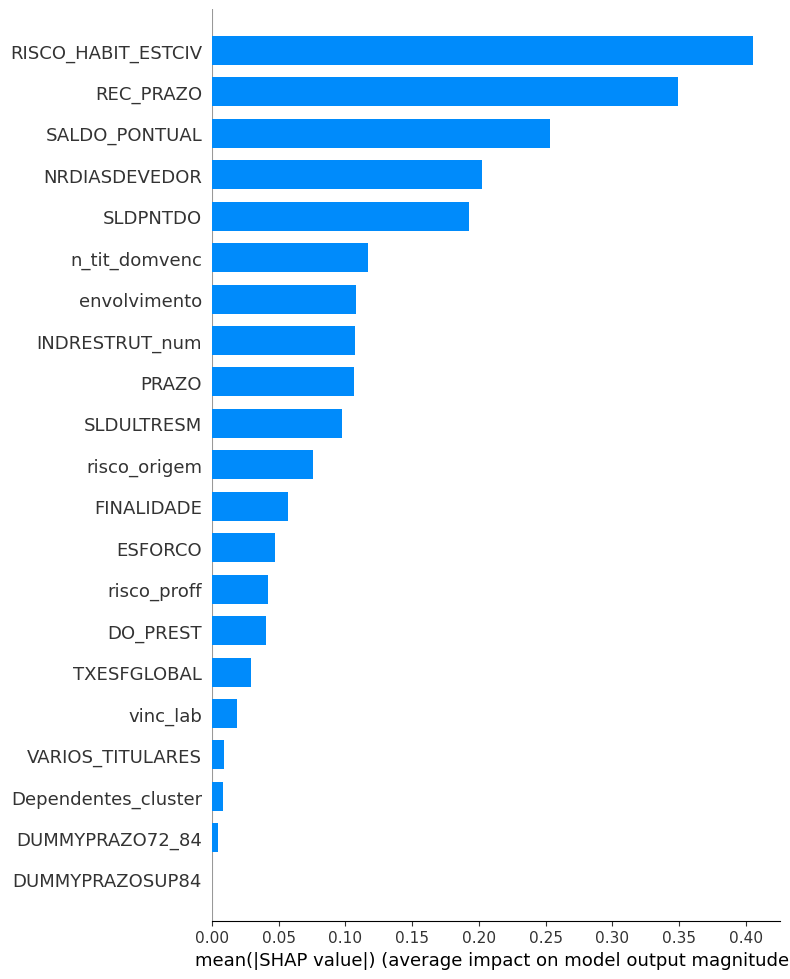

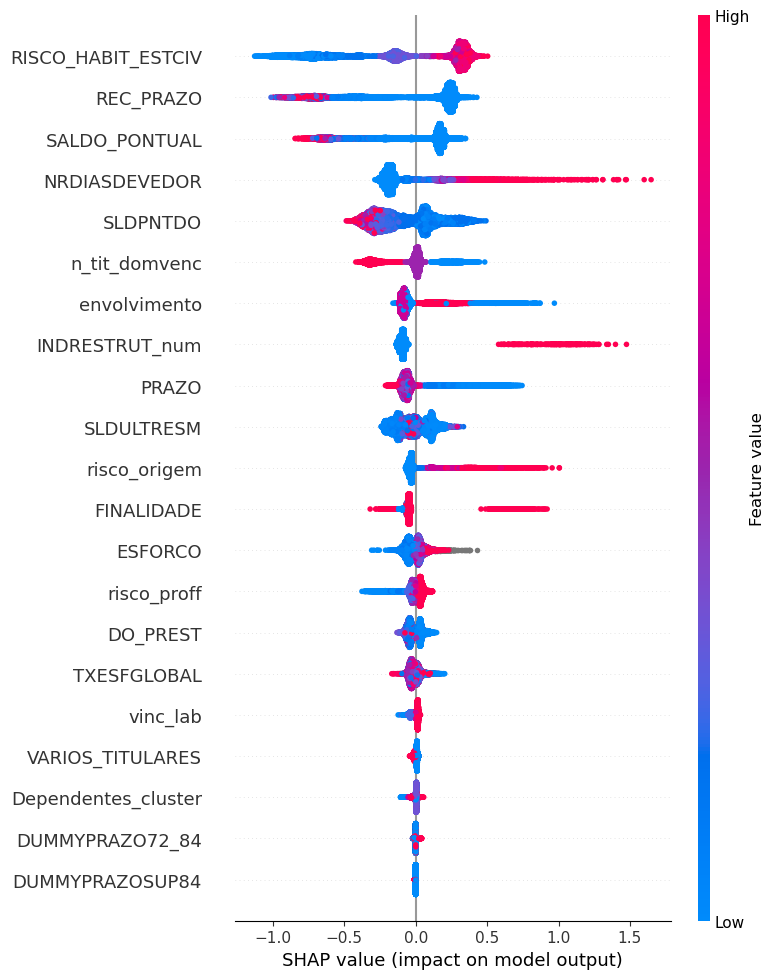

Default predictions


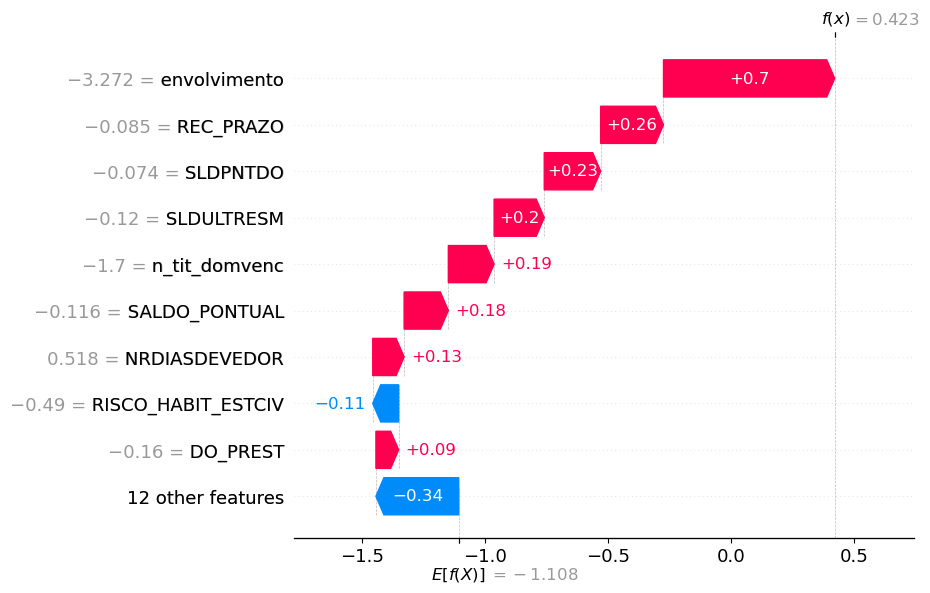

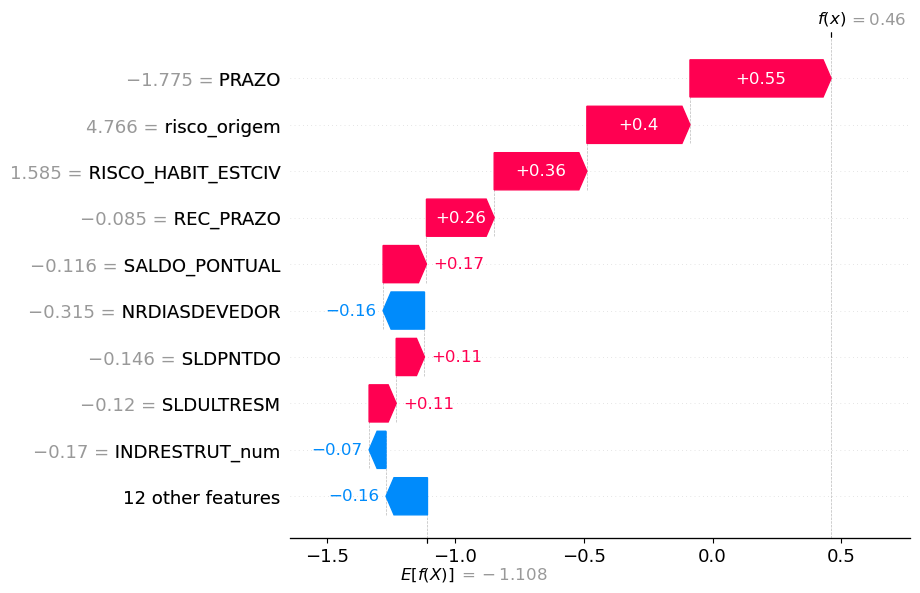

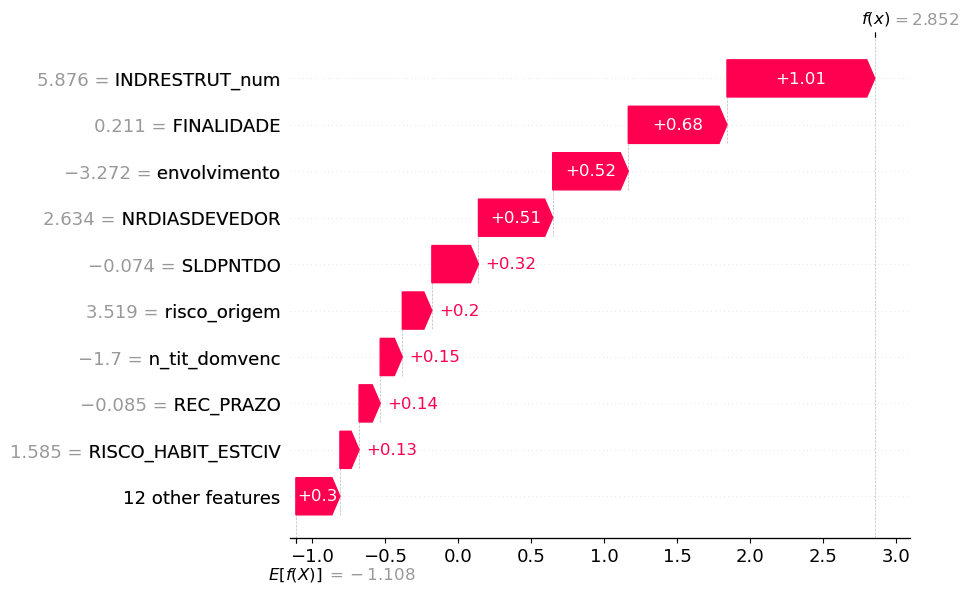

Non default prediction


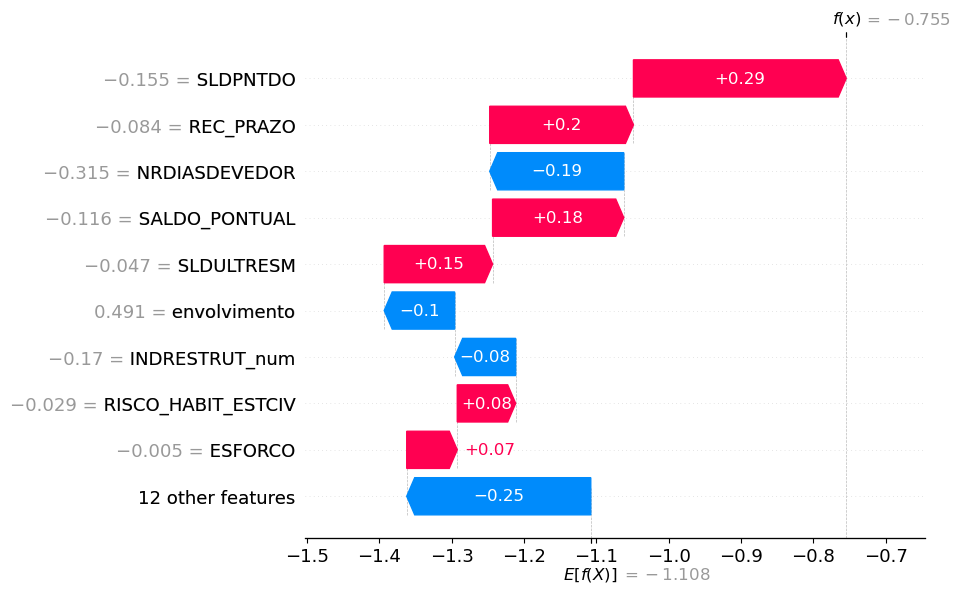

In [47]:
path = "/lakehouse/default/Files/WorkerFactory/DADOS_CLIENTES.csv" #"/lakehouse/default/Files/WorkerFactory/AMOSTRA_NOVOS.csv"
df = preprocess_features_v2(path)

X_train, X_test, y_train, y_test, feature_names = load_and_prepare_data(df, 'DEF_12', 'DTREF', 2023) 
X_train_balanced, y_train_balanced = balance_data(X_train, y_train, 'DEF_12', method='undersample')
best_model, best_params = hyperparameter_tuning(X_train_balanced, y_train_balanced, cv_folds=5)
cv_results = cross_validation_evaluation(best_model, X_train_balanced, y_train_balanced, cv_folds=5)
final_model = train_final_model(X_train_balanced, y_train_balanced, best_params)

train_metrics, test_metrics, y_train_pred, y_test_pred, y_train_proba, y_test_proba = evaluate_model(X_train, y_train, X_test, y_test, final_model)

print_metrics_report(train_metrics, test_metrics)
plot_results(y_train, y_test, y_train_pred, y_test_pred,
                               y_train_proba, y_test_proba, train_metrics, test_metrics, final_model, feature_names)

explainerx, shap_values_trainx, shap_values_testx, X_train_samplex, X_test_samplex = generate_shap_explanations(X_train, X_test, final_model)

importance_df = shap_global_importance(shap_values_testx, feature_names, top_n=21)

plot_shap_analysis(explainerx, shap_values_testx, X_test_samplex, feature_names)

# RUN PIPELINE

In [ ]:
def run_pipeline():

 #pipeline

 #save model and results

# Inicializar o modelo
""" 
# class name!!!
model = DefaultPredictionModel(target_ratio=0.25)  # 25% = 1:3 ratio

# Executar pipeline completo
results = model.run_complete_pipeline(
    df=df,
    target_column='default',  # nome da sua coluna target
    date_column='data',       # nome da sua coluna de data
    balance_method='smote_tomek',  # ou 'smote' ou 'undersample'
    cv_folds=5
)

# Acessar resultados
final_model = results['model']
test_metrics = results['test_metrics']
print(f"AUC no teste: {test_metrics['auc']:.4f}")
"""

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, -1, Cancelled, , Cancelled)

In [25]:
df1 = pd.read_csv("/lakehouse/default/Files/WorkerFactory/DADOS_NOVOS_CLIENTES.csv", sep=";").drop(columns=['estciv_final_num', 'flag_garant', 'naciona_final_num', 'SALDO_PONTUAL', 'naciona_rend_num', 'envolvimento'])
df2 = pd.read_csv("/lakehouse/default/Files/WorkerFactory/AMOSTRA_NOVOS.csv", sep=";")

df1.head()

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 29, Finished, Available, Finished)

,IDRFME,DTREF,ANO,MES,TIMEID,DEF_12,nr_titulares,nr_outros_interv,PREST,max_escolaridade,min_escolaridade,max_risco_regiao,min_risco_regiao,n_tit_domvenc,med_domvenc,med_dias_devedor,flag_nao_resi,med_idade,younger,older,avg_dependentes,flag_resec,med_filhos,med_idade_filhos,med_rend_disp,pior_habitacao,best_habitacao,flag_resi,pior_vinclab,best_vinclab,best_prof2,pior_prof2,max_risco_origem2,min_risco_origem2,pior_estciv,best_estciv,CDTIPES,EXPOSICAO,MTLINHASDISP,PRAZO,FINALIDADE,FLAG_REEST,TXESFGLOBAL,FLG14PREST,OUT_VALPREST,INVALPRESTDUPLA,OUTVALPRESTDUPLA,CARNUM,PCTVALRES,SLDULTRESM,SLDPNTBSCAP1M,SLDPNTBSPPR,SLDPNTFUND,SLDPNTDEPPRZ,SLDPNTOUTDES,VALPRESTDUPLA,DO_PREST,DUMMYAUTONOVO,DUMMYPRAZO72_84,DUMMYPRAZOSUP84,DUMMYDOMVENC_AVAL,DUMMYRECPRAZO,DUMMYIFSUP5TC,INCTC,NUM_DEB_FINALtc,REC_PRAZO,NRDIASDEVEDOR,SLDPNTDO,SLDMDDOTM,SLDPNTTITRV,PLATRDIARIOCC,MEDR1MCC,MEDRADCC,MEDR1MCI,MEDRADCI,PRESTDIARIACI,MEDR1MCH,MEDRADCH,PRESTDIARIACH,MEDR1MCHP,SLDMDDEVAD,SLDMDDEV1M,SLDMDDEV3M,SLDMDDEV6M,TPRESTFRONTENDCI,flag_garant,flag_fin,envolvimento,ANTCONTA1,VARIOS_TITULARES,INDRESTRUT_num,flag14prest,SALDO_PONTUAL,naciona_final_num,naciona_rend_num,estciv_final_num
0,AA60013666377,2015-01-31,2015,1,201501,0,2,0,118.91,3,3,10,10,0,NaN,0,0,43.5,41,46,0.5,0,0.0,0.0,35.211667,3,1,1,2,2,5,6,2,2,5,1,P,6981.30,0.0,84,98,1,89.741,N,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,1,0,0,0,1,0,0.0,0.000000,0.0,NaN,NaN,NaN,6250.0,6271.646000,6431.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,1,1,NaN,1,1,0,0.0,0,0,1
1,AA60013672532,2015-01-31,2015,1,201501,0,1,0,208.23,3,3,8,8,1,NaN,0,0,27.0,27,27,0.0,0,0.0,0.0,1105.166667,5,5,1,2,2,3,3,2,2,5,5,P,7558.34,0.0,72,98,0,12.683,N,0.0,0.0,0.0,0,30.0,284.000000,0.0,0.0,0.0,1400.0,0.0,0.0,136.387648,0,0,0,0,1,0,0,17.0,212.666667,0.0,604.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,1,1,2,NaN,0,0,0,1400.0,0,0,1
2,AA60013672906,2015-01-31,2015,1,201501,0,2,0,124.80,1,1,8,1,0,NaN,0,0,26.0,25,27,0.0,0,0.0,0.0,498.671000,2,1,1,1,1,4,6,2,2,2,2,P,5289.68,0.0,60,98,0,15.809,N,0.0,0.0,0.0,0,0.0,119.666667,0.0,0.0,0.0,0.0,0.0,0.0,95.886752,0,0,0,0,0,0,0,27.0,0.000000,0.0,6.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33540.0,33504.47,121.62,NaN,0.00,NaN,NaN,NaN,0.0,1,1,4,NaN,1,0,0,0.0,0,0,6
3,AA60013673026,2015-01-31,2015,1,201501,0,1,0,97.93,1,1,3,3,1,NaN,0,0,28.0,28,28,0.0,0,0.0,0.0,1007.736667,5,5,1,1,1,6,6,2,2,5,5,P,4222.97,0.0,60,98,0,7.085,N,0.0,0.0,0.0,0,0.0,177.666667,0.0,0.0,0.0,40.0,0.0,0.0,181.422105,0,0,0,0,1,0,0,21.0,20.666667,0.0,179.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,1,1,2,NaN,0,0,0,40.0,0,0,1
4,AA60013673384,2015-01-31,2015,1,201501,0,1,1,193.58,1,1,8,8,0,NaN,28,0,64.0,64,64,0.0,0,0.0,0.0,646.420000,5,5,1,2,2,4,4,2,2,1,1,P,10088.52,0.0,72,98,1,43.538,N,0.0,0.0,0.0,0,0.0,169.333333,0.0,0.0,0.0,0.0,0.0,0.0,87.474601,0,0,0,0,0,0,0,21.0,485.085853,28.0,-1055.82,144.333333,NaN,8750.0,6111.037667,5758.23,3945.83,3481.16,263.57,NaN,NaN,NaN,NaN,1055.82,4.0,153.0,76.5,0.0,0,1,2,NaN,0,1,0,0.0,0,0,2


In [26]:
df2.head()

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 30, Finished, Available, Finished)

,IDRFME,DTREF,ANO,MES,TIMEID,DEF_12,nr_titulares,nr_outros_interv,PREST,max_escolaridade,min_escolaridade,max_risco_regiao,min_risco_regiao,n_tit_domvenc,med_domvenc,med_dias_devedor,flag_nao_resi,med_idade,younger,older,avg_dependentes,flag_resec,med_filhos,med_idade_filhos,med_rend_disp,pior_habitacao,best_habitacao,flag_resi,pior_vinclab,best_vinclab,best_prof2,pior_prof2,max_risco_origem2,min_risco_origem2,pior_estciv,best_estciv,CDTIPES,EXPOSICAO,MTLINHASDISP,PRAZO,FINALIDADE,FLAG_REEST,TXESFGLOBAL,FLG14PREST,OUT_VALPREST,INVALPRESTDUPLA,OUTVALPRESTDUPLA,CARNUM,PCTVALRES,SLDULTRESM,SLDPNTBSCAP1M,SLDPNTBSPPR,SLDPNTFUND,SLDPNTDEPPRZ,SLDPNTOUTDES,VALPRESTDUPLA,DO_PREST,DUMMYAUTONOVO,DUMMYPRAZO72_84,DUMMYPRAZOSUP84,DUMMYDOMVENC_AVAL,DUMMYRECPRAZO,DUMMYIFSUP5TC,INCTC,NUM_DEB_FINALtc,REC_PRAZO,NRDIASDEVEDOR,SLDPNTDO,SLDMDDOTM,SLDPNTTITRV,PLATRDIARIOCC,MEDR1MCC,MEDRADCC,MEDR1MCI,MEDRADCI,PRESTDIARIACI,MEDR1MCH,MEDRADCH,PRESTDIARIACH,MEDR1MCHP,SLDMDDEVAD,SLDMDDEV1M,SLDMDDEV3M,SLDMDDEV6M,TPRESTFRONTENDCI,flag_fin,ANTCONTA1,VARIOS_TITULARES,INDRESTRUT_num,flag14prest,FLAG_ENI
0,AA60013666377,2015-01-31,2015,1,201501,0,2,0,118.91,3,3,10,10,0,NaN,0,0,43.5,41,46,0.5,0,0.0,0.0,35.211667,3,1,1,2,2,5,6,2,2,5,1,P,6981.30,0.0,84,98,1,89.741,N,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,1,0,0,0,1,0,0.0,0.000000,0.0,NaN,NaN,NaN,6250.0,6271.646000,6431.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,NaN,1,1,0,0
1,AA60013672532,2015-01-31,2015,1,201501,0,1,0,208.23,3,3,8,8,1,NaN,0,0,27.0,27,27,0.0,0,0.0,0.0,1105.166667,5,5,1,2,2,3,3,2,2,5,5,P,7558.34,0.0,72,98,0,12.683,N,0.0,0.0,0.0,0,30.0,284.000000,0.0,0.0,0.0,1400.0,0.0,0.0,136.387648,0,0,0,0,1,0,0,17.0,212.666667,0.0,604.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,1,NaN,0,0,0,0
2,AA60013672906,2015-01-31,2015,1,201501,0,2,0,124.80,1,1,8,1,0,NaN,0,0,26.0,25,27,0.0,0,0.0,0.0,498.671000,2,1,1,1,1,4,6,2,2,2,2,P,5289.68,0.0,60,98,0,15.809,N,0.0,0.0,0.0,0,0.0,119.666667,0.0,0.0,0.0,0.0,0.0,0.0,95.886752,0,0,0,0,0,0,0,27.0,0.000000,0.0,6.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33540.0,33504.47,121.62,NaN,0.00,NaN,NaN,NaN,0.0,1,NaN,1,0,0,0
3,AA60013673026,2015-01-31,2015,1,201501,0,1,0,97.93,1,1,3,3,1,NaN,0,0,28.0,28,28,0.0,0,0.0,0.0,1007.736667,5,5,1,1,1,6,6,2,2,5,5,P,4222.97,0.0,60,98,0,7.085,N,0.0,0.0,0.0,0,0.0,177.666667,0.0,0.0,0.0,40.0,0.0,0.0,181.422105,0,0,0,0,1,0,0,21.0,20.666667,0.0,179.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,1,NaN,0,0,0,0
4,AA60013673384,2015-01-31,2015,1,201501,0,1,1,193.58,1,1,8,8,0,NaN,28,0,64.0,64,64,0.0,0,0.0,0.0,646.420000,5,5,1,2,2,4,4,2,2,1,1,P,10088.52,0.0,72,98,1,43.538,N,0.0,0.0,0.0,0,0.0,169.333333,0.0,0.0,0.0,0.0,0.0,0.0,87.474601,0,0,0,0,0,0,0,21.0,485.085853,28.0,-1055.82,144.333333,NaN,8750.0,6111.037667,5758.23,3945.83,3481.16,263.57,NaN,NaN,NaN,NaN,1055.82,4.0,153.0,76.5,0.0,1,NaN,0,1,0,0


In [27]:
print(len(df1.columns)) # dados tudo
print(len(df2.columns)) # dados que uso

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 31, Finished, Available, Finished)

96
91


In [29]:
df2 = pd.read_csv("/lakehouse/default/Files/WorkerFactory/AMOSTRA_NOVOS.csv", sep=";")
df2

# Colunas em df1 que não estão em df2
colunas_somente_df1 = set(df1.columns) - set(df2.columns)

print("Colunas só em df1:", colunas_somente_df1)



StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 33, Finished, Available, Finished)

Colunas só em df1: {'estciv_final_num', 'flag_garant', 'naciona_final_num', 'SALDO_PONTUAL', 'naciona_rend_num', 'envolvimento'}


In [21]:
df2.head()

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 25, Finished, Available, Finished)

,IDRFME,DTREF,ANO,MES,TIMEID,DEF_12,nr_titulares,nr_outros_interv,PREST,max_escolaridade,min_escolaridade,max_risco_regiao,min_risco_regiao,n_tit_domvenc,med_domvenc,med_dias_devedor,flag_nao_resi,med_idade,younger,older,avg_dependentes,flag_resec,med_filhos,med_idade_filhos,med_rend_disp,pior_habitacao,best_habitacao,flag_resi,pior_vinclab,best_vinclab,best_prof2,pior_prof2,max_risco_origem2,min_risco_origem2,pior_estciv,best_estciv,CDTIPES,EXPOSICAO,MTLINHASDISP,PRAZO,FINALIDADE,FLAG_REEST,TXESFGLOBAL,FLG14PREST,OUT_VALPREST,INVALPRESTDUPLA,OUTVALPRESTDUPLA,CARNUM,PCTVALRES,SLDULTRESM,SLDPNTBSCAP1M,SLDPNTBSPPR,SLDPNTFUND,SLDPNTDEPPRZ,SLDPNTOUTDES,VALPRESTDUPLA,DO_PREST,DUMMYAUTONOVO,DUMMYPRAZO72_84,DUMMYPRAZOSUP84,DUMMYDOMVENC_AVAL,DUMMYRECPRAZO,DUMMYIFSUP5TC,INCTC,NUM_DEB_FINALtc,REC_PRAZO,NRDIASDEVEDOR,SLDPNTDO,SLDMDDOTM,SLDPNTTITRV,PLATRDIARIOCC,MEDR1MCC,MEDRADCC,MEDR1MCI,MEDRADCI,PRESTDIARIACI,MEDR1MCH,MEDRADCH,PRESTDIARIACH,MEDR1MCHP,SLDMDDEVAD,SLDMDDEV1M,SLDMDDEV3M,SLDMDDEV6M,TPRESTFRONTENDCI,flag_fin,ANTCONTA1,VARIOS_TITULARES,INDRESTRUT_num,flag14prest,FLAG_ENI
0,AA60013666377,2015-01-31,2015,1,201501,0,2,0,118.91,3,3,10,10,0,NaN,0,0,43.5,41,46,0.5,0,0.0,0.0,35.211667,3,1,1,2,2,5,6,2,2,5,1,P,6981.30,0.0,84,98,1,89.741,N,0.0,0.0,0.0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,1,0,0,0,1,0,0.0,0.000000,0.0,NaN,NaN,NaN,6250.0,6271.646000,6431.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,NaN,1,1,0,0
1,AA60013672532,2015-01-31,2015,1,201501,0,1,0,208.23,3,3,8,8,1,NaN,0,0,27.0,27,27,0.0,0,0.0,0.0,1105.166667,5,5,1,2,2,3,3,2,2,5,5,P,7558.34,0.0,72,98,0,12.683,N,0.0,0.0,0.0,0,30.0,284.000000,0.0,0.0,0.0,1400.0,0.0,0.0,136.387648,0,0,0,0,1,0,0,17.0,212.666667,0.0,604.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,1,NaN,0,0,0,0
2,AA60013672906,2015-01-31,2015,1,201501,0,2,0,124.80,1,1,8,1,0,NaN,0,0,26.0,25,27,0.0,0,0.0,0.0,498.671000,2,1,1,1,1,4,6,2,2,2,2,P,5289.68,0.0,60,98,0,15.809,N,0.0,0.0,0.0,0,0.0,119.666667,0.0,0.0,0.0,0.0,0.0,0.0,95.886752,0,0,0,0,0,0,0,27.0,0.000000,0.0,6.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33540.0,33504.47,121.62,NaN,0.00,NaN,NaN,NaN,0.0,1,NaN,1,0,0,0
3,AA60013673026,2015-01-31,2015,1,201501,0,1,0,97.93,1,1,3,3,1,NaN,0,0,28.0,28,28,0.0,0,0.0,0.0,1007.736667,5,5,1,1,1,6,6,2,2,5,5,P,4222.97,0.0,60,98,0,7.085,N,0.0,0.0,0.0,0,0.0,177.666667,0.0,0.0,0.0,40.0,0.0,0.0,181.422105,0,0,0,0,1,0,0,21.0,20.666667,0.0,179.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,1,NaN,0,0,0,0
4,AA60013673384,2015-01-31,2015,1,201501,0,1,1,193.58,1,1,8,8,0,NaN,28,0,64.0,64,64,0.0,0,0.0,0.0,646.420000,5,5,1,2,2,4,4,2,2,1,1,P,10088.52,0.0,72,98,1,43.538,N,0.0,0.0,0.0,0,0.0,169.333333,0.0,0.0,0.0,0.0,0.0,0.0,87.474601,0,0,0,0,0,0,0,21.0,485.085853,28.0,-1055.82,144.333333,NaN,8750.0,6111.037667,5758.23,3945.83,3481.16,263.57,NaN,NaN,NaN,NaN,1055.82,4.0,153.0,76.5,0.0,1,NaN,0,1,0,0


In [23]:
len(df1.drop(columns=['estciv_final_num', 'flag_garant', 'naciona_final_num', 'SALDO_PONTUAL', 'naciona_rend_num', 'envolvimento']).columns)

StatementMeta(, 902ff30e-14a2-4868-9672-5b06a82e12cf, 27, Finished, Available, Finished)

90